# 05 - Hierarchical Models - Partially Pooled

In [1]:
import sys
import os
from pathlib import Path 

import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import xarray as xr
import theano.tensor as tt
import bambi as bmb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import plotnine as p9

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))

from projects.common.berlin_housing.utils.plot_utils import set_plot_defaults, plot_price_area
from projects.common.berlin_housing.utils.data_utils import load_data
from projects.common.berlin_housing.utils.data_utils import destandardize_area, destandardize_price, load_data, standardize_area
from projects.common.berlin_housing.utils.plot_utils import set_plot_defaults, draw_model_plot

DATA_DIR = PROJECT_DIR / 'data'  / 'berlin_housing' / 'interim_data'
DATA_DIR

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/data/berlin_housing/interim_data')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
xr.set_options(display_expand_data=False, display_expand_attrs=False, display_expand_coords=False,
              display_expand_data_vars=False)
SEED = 1925

%load_ext watermark
%watermark --iversions

bambi     : 0.6.3
seaborn   : 0.11.2
arviz     : 0.11.2
plotnine  : 0.8.0
numpy     : 1.19.5
sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) 
[GCC 9.4.0]
pymc3     : 3.11.4
theano    : 1.1.2
pandas    : 1.3.2
matplotlib: 3.4.3
xarray    : 0.19.0



# Data Prep
+ Data cut to rentals < 7,500 pcm to make scatterplots more readable
+ 

In [3]:
df_orig, _, _ = load_data(kind="rents")
df_orig = df_orig[df_orig['rent'] < 7500]
keepers = ['rent', 'zip', 'living_space']
df_orig = df_orig[keepers].reset_index(drop=True)
df_orig['zip'] = df_orig['zip'].astype('category')
df_orig.head()

,rent,zip,living_space
0,941.0,12103,31.00
1,1399.7,14109,82.34
2,830.0,13086,100.59
3,3417.6,10785,213.60
4,490.0,12057,49.00


In [4]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7244 entries, 0 to 7243
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   rent          7244 non-null   float64 
 1   zip           7244 non-null   category
 2   living_space  7244 non-null   float64 
dtypes: category(1), float64(2)
memory usage: 137.2 KB


# Data Prep

In [5]:
df = df_orig.copy()
zips = df['zip'].value_counts().reset_index().rename(columns={'index': 'zip', 'zip': 'zip_count'})
zip_list = df['zip'].value_counts().index.tolist()
zips.head()

,zip,zip_count
0,10115,206
1,10557,195
2,10117,154
3,12627,143
4,12555,140


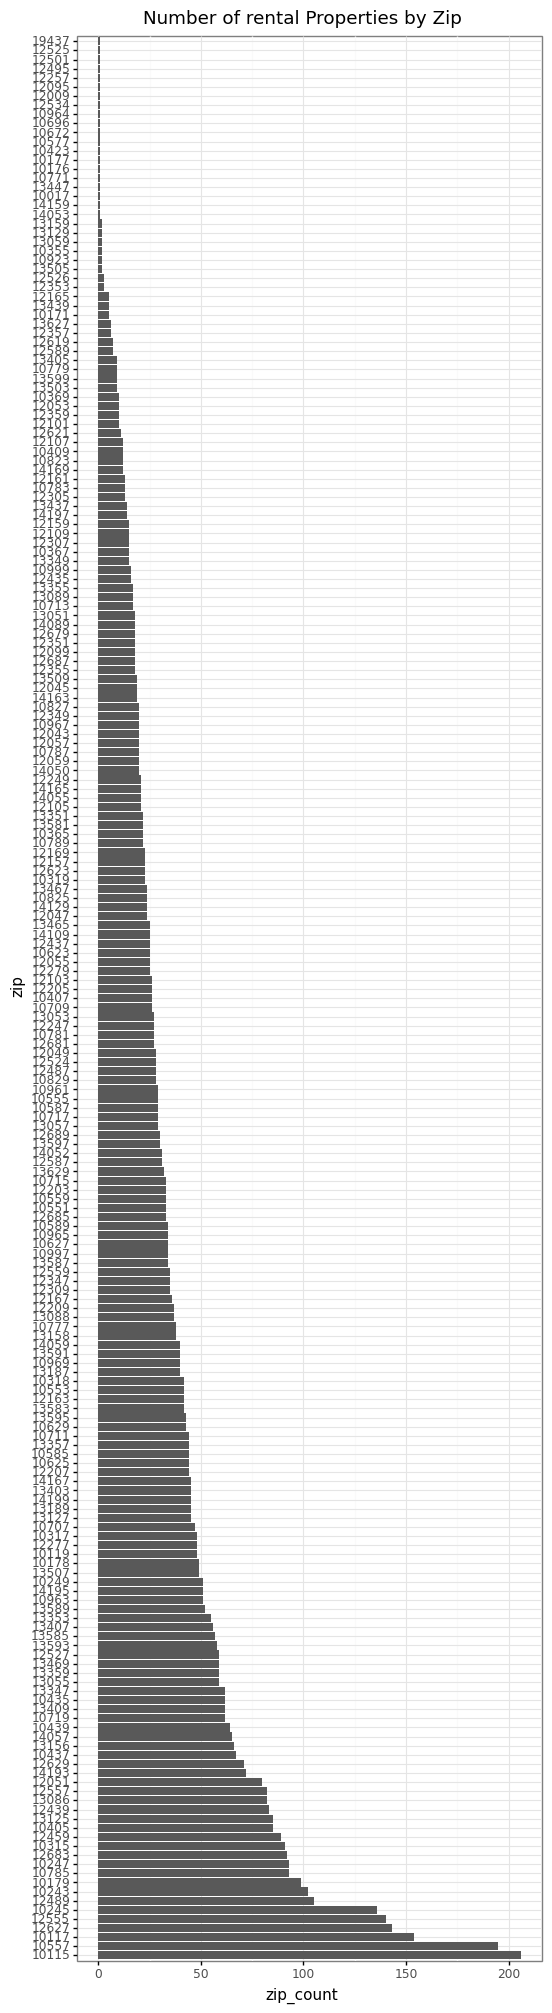

In [6]:
p = (ggplot(zips, aes(x='zip', y='zip_count')) +
     geom_col() +
     theme(figure_size=(6,25)) +
     scale_x_discrete(limits=zip_list) +
     labs(title='Number of rental Properties by Zip') +
     coord_flip()
    )
p.draw();

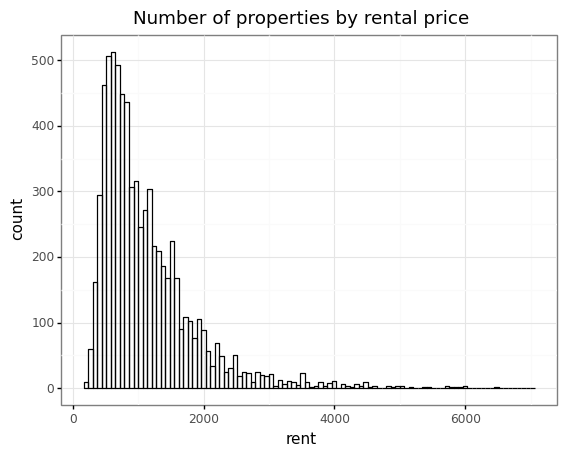

In [7]:
df = df[df['rent'] < 7500]
p = (ggplot(df, aes('rent')) +
     geom_histogram(bins=100, color='black', fill='none') +
     labs(title='Number of properties by rental price') 
    )
p.draw();

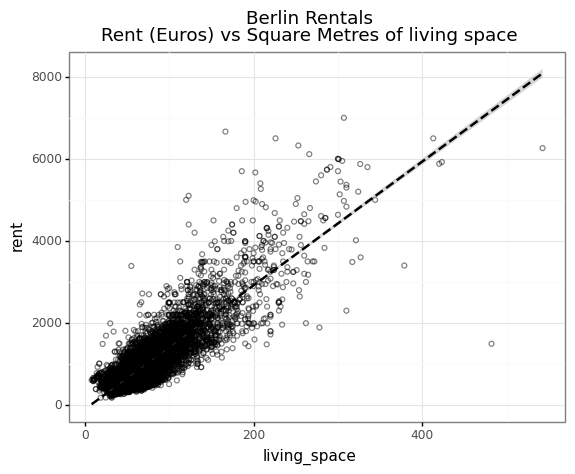

In [8]:
p = (ggplot(df, aes(x='living_space', y='rent'))+
     geom_point(fill='none', color='black', alpha=0.5) +
     geom_smooth(method='lm', linetype='dashed') +
     labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space')
    )
p.draw();

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars


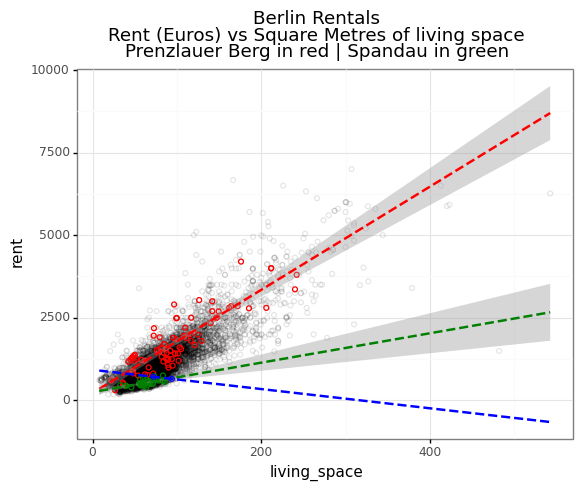

In [9]:
p = (ggplot(df, aes(x='living_space', y='rent'))+
     geom_point(fill='none', color='black', alpha=0.1) +
     geom_point(df[df['zip']=='10405'], aes(x='living_space', y='rent'), color='red', fill='none') +
     geom_smooth(df[df['zip']=='10405'], method='lm', color='red', linetype='dashed', fullrange=True) +
     geom_point(df[df['zip']=='13583'], aes(x='living_space', y='rent'), color='green', fill='none') +
     geom_smooth(df[df['zip']=='13583'], method='lm', color='green', linetype='dashed', fullrange=True) +
     geom_point(df[df['zip']=='13129'], aes(x='living_space', y='rent'), color='blue', fill='none') +
     geom_smooth(df[df['zip']=='13129'], method='lm', color='blue', linetype='dashed', fullrange=True) +
     labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space\nPrenzlauer Berg in red | Spandau in green')
    )
p.draw();

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars


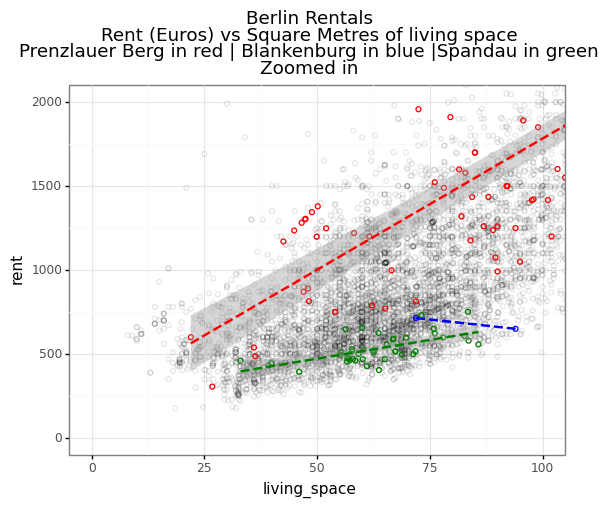

In [10]:
p = (ggplot(df, aes(x='living_space', y='rent'))+
     geom_point(fill='none', color='black', alpha=0.1) +
     geom_point(df[df['zip']=='13129'], aes(x='living_space', y='rent'), color='blue', fill='none') +
     geom_smooth(df[df['zip']=='13129'], method='lm', color='blue', linetype='dashed', fullrange=False) +
     geom_point(df[df['zip']=='10405'], aes(x='living_space', y='rent'), color='red', fill='none') +
     geom_smooth(df[df['zip']=='10405'], method='lm', color='red', linetype='dashed', fullrange=False) +
     geom_point(df[df['zip']=='13583'], aes(x='living_space', y='rent'), color='green', fill='none') +
     geom_smooth(df[df['zip']=='13583'], method='lm', color='green', linetype='dashed', fullrange=False) +
     coord_cartesian(xlim=(0, 100), ylim=(0, 2000)) +
     labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space\nPrenzlauer Berg in red | Blankenburg in blue |Spandau in green\nZoomed in')
    )
p.draw();

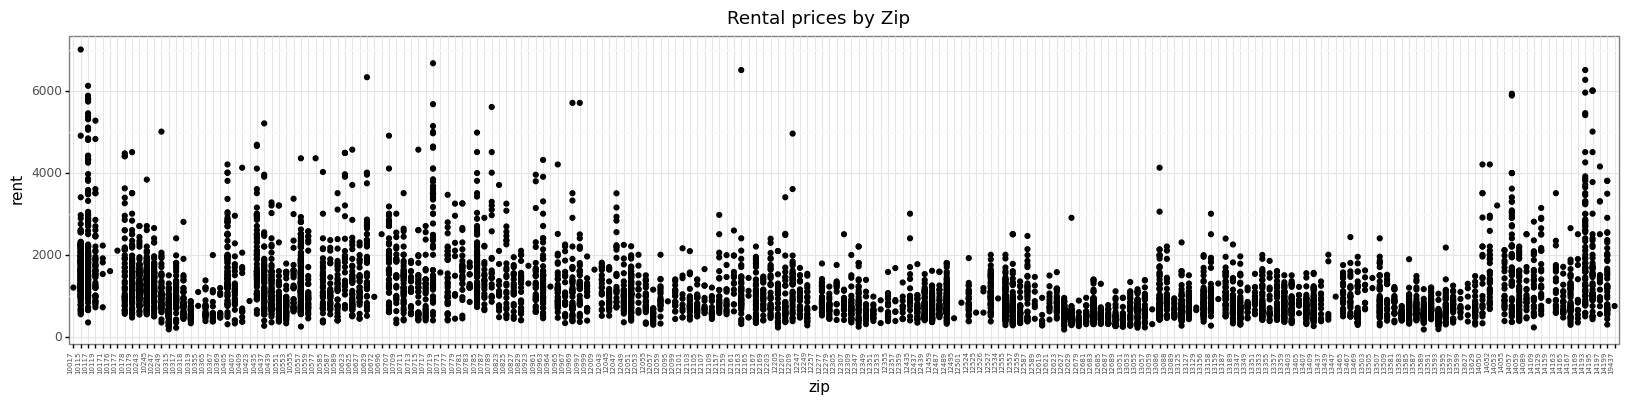

In [11]:
df = df_orig.copy()
p = (ggplot(df, aes(x='zip', y='rent')) +
     geom_point() +
     theme(figure_size=(20, 4)) +
     theme(axis_text_x = element_text(angle = 90, hjust=1, size=5)) +
     labs(title='Rental prices by Zip')
    )
p.draw();


In [12]:
df

,rent,zip,living_space
0,941.00,12103,31.00
1,1399.70,14109,82.34
2,830.00,13086,100.59
3,3417.60,10785,213.60
4,490.00,12057,49.00
...,...,...,...
7239,1170.00,10997,63.36
7240,378.95,10367,34.45
7241,579.00,12559,60.00
7242,1748.00,10557,95.00


## Comments
+ As a general trend rental price increases as living space (square metres) increases
+ ~ 20 zip codes have only one rent price - cannot model a linear relationship with just one point
+ Plenty of zip codes with 2,3, or 4 points. This is a small sample size, so modeling will most likely not be reliable - See Blankenburg above.
+ Clearly Spandau has a different regression slope to Prenzlauer Berg, and both will most likely have a different regression line to the full dataset.
+ Modeling Options
    + Unpooled parameters

# Data Preparation

In [13]:
def prep_data(df_orig):
    df = df_orig.copy()
    # Cut back dataset to target and 2 variables
    keepers1 = ['rent', 'living_space', 'zip']
    keepers2 = ['rent_scaled', 'living_space_ctrd', 'zip']
    # Cleanup zip column and make codes
    df['zip'] = df['zip'].astype('str').str.strip().astype('category')
    df['zip_coded'] = df['zip'].cat.codes
    df['zip_coded'] = df['zip_coded'].astype('category')
    # Centre living space
    df['living_space_ctrd'] = df['living_space'] - df['living_space'].mean()
    # Scale the rent to 1000s
    df['rent_scaled'] = df['rent']/10
    return df.reset_index(drop=True)

dfm = prep_data(df_orig)
dfm1 = dfm.copy()[['rent_scaled', 'living_space_ctrd', 'zip_coded']]
dfm1.head()

,rent_scaled,living_space_ctrd,zip_coded
0,94.10,-50.864215,84
1,139.97,0.475785,199
2,83.00,18.725785,148
3,341.76,131.735785,55
4,49.00,-32.864215,79


In [14]:
num_zip_codes = len(dfm1['zip_coded'].cat.categories)
num_zip_codes

211

In [15]:
zip_coded = dfm1['zip_coded'].values
zip_coded

[84, 199, 148, 55, 79, ..., 69, 19, 129, 31, 93]
Length: 7244
Categories (211, int64): [0, 1, 2, 3, ..., 207, 208, 209, 210]

In [16]:
target= 'rent_scaled'

In [17]:
zip_codes = np.sort(dfm1.zip_coded.unique())
zip_codes[0:5]

array([0, 1, 2, 3, 4])

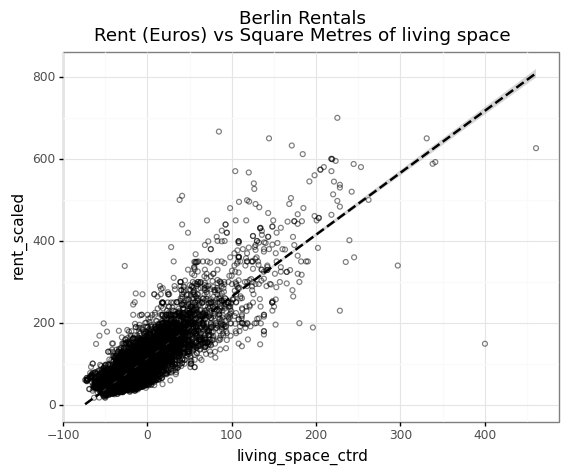

In [18]:
p = (ggplot(dfm1, aes(x='living_space_ctrd', y='rent_scaled'))+
     geom_point(fill='none', color='black', alpha=0.5) +
     geom_smooth(method='lm', linetype='dashed') +
     labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space')
    )
p.draw();

In [19]:
# num_zip_codes = len(dfm1['zip_coded'].cat.categories)
# num_zip_codes

# Hierarchical Model
In this notebook, we implement the following hierarchical model in PyMC:

$$\begin{align*}
y &\sim \text{Normal}(\mu, \sigma)\\
\mu &= \alpha_{[ZIP]} + \beta_{[ZIP]} \text{area}\\
\alpha_{[ZIP]} &\sim \text{Normal}(\mu_{\alpha},\sigma_{\alpha}) \\
\beta_{[ZIP]} &\sim \text{Normal}(\mu_{\beta},\sigma_{\beta}) \\
\mu_{\alpha}, \mu_{\beta} &\sim \text{Normal}(0,100) \\
\sigma, \sigma_{\alpha}, \sigma_{\beta} &\sim \text{Exponential}(100)
\end{align*}$$

There are different ways to encode this model. The naive version is to use a center parametrization, however, for many problems this is not an optimal and a reparameterization, the non-centered version is a better alternative.
Another way to encode a hierarchical model, is to use instead a multivariate normal. I will present all three versions here.

## Not very good Model
here, I actually accidently let $\sigma$ also vary by ZIP code. The idea in itself is actually not that stupid (makes sense that some heterogeneous ZIP codes vary maybe more than others in the price) but this implementation fails, as you can see in the trace plots. I leave it here just to give an example of some bad trace plots.

In [20]:
with pm.Model() as hier_model_naiv:
    mu_alpha = pm.Normal("mu_alpha", mu=0, sd=20)
    sigma_alpha = pm.Exponential("sigma_alpha", lam=1/2.5)
    
    mu_beta = pm.Normal("mu_beta", mu=0, sd=5)
    sigma_beta = pm.Exponential("sigma_beta", lam=1/2.5)
    
    alpha = pm.Normal("alpha", mu=mu_alpha, sd=sigma_alpha, shape=num_zip_codes)
    beta = pm.Normal("beta", mu=mu_beta, sd=sigma_beta, shape=num_zip_codes)
    # sigma also varies by zip code
    sigma = pm.Exponential("sigma", lam=1/2.5, shape=num_zip_codes)
    
    mu = alpha[dfm.zip_coded.values] + beta[dfm.zip_coded.values]*dfm.living_space_ctrd
    y = pm.Normal("y", mu=mu, sd=sigma[dfm.zip_coded.values], observed=dfm[target])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)

/tmp/ipykernel_24002/731173252.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 204 seconds.
There were 954 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3560250723127532, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.2674142860119368, but should be close to 0.8. Try to increase the number of tuning steps.
There were 513 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.28432280933517795, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number 

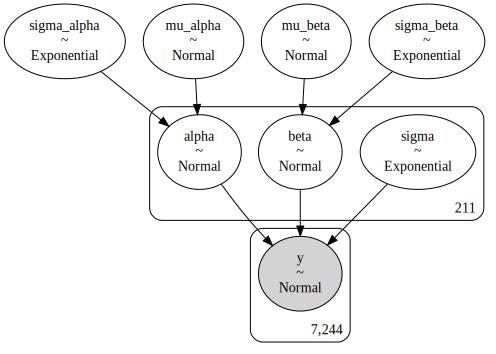

In [21]:
pm.model_to_graphviz(hier_model_naiv)

In [22]:
idata_bad_model = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=posterior_predictive,
                     coords={'zip_code': zip_codes},
                     dims={"alpha": ["zip_code"], "beta": ["zip_code"],
                          "sigma": ["zip_code"]})
idata_bad_model

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [23]:
# print(DATA_DIR.parent / 'models' / 'bad_model.nc')
# bad_model.to_netcdf(DATA_DIR.parent / 'models' / 'bad_model.nc')

In [24]:
az.summary(idata_bad_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,78.348,44.912,0.617,106.675,22.357,17.117,6.0,13.0,1.82
mu_beta,1.115,0.086,0.974,1.214,0.042,0.032,5.0,15.0,2.12
alpha[0],85.046,49.235,-0.041,117.721,24.476,18.735,7.0,27.0,1.68
alpha[1],108.556,62.443,0.444,146.914,31.090,23.804,6.0,11.0,1.76
alpha[2],113.598,65.658,0.045,157.175,32.663,25.005,6.0,12.0,2.22
...,...,...,...,...,...,...,...,...,...
sigma[206],80.551,40.906,54.055,151.843,20.344,15.590,7.0,16.0,1.85
sigma[207],78.322,47.785,44.384,161.464,23.774,18.215,5.0,40.0,2.40
sigma[208],47.717,41.471,20.723,123.041,20.627,15.805,6.0,16.0,1.87
sigma[209],59.074,27.162,38.316,107.621,13.469,10.333,6.0,26.0,1.87


/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide


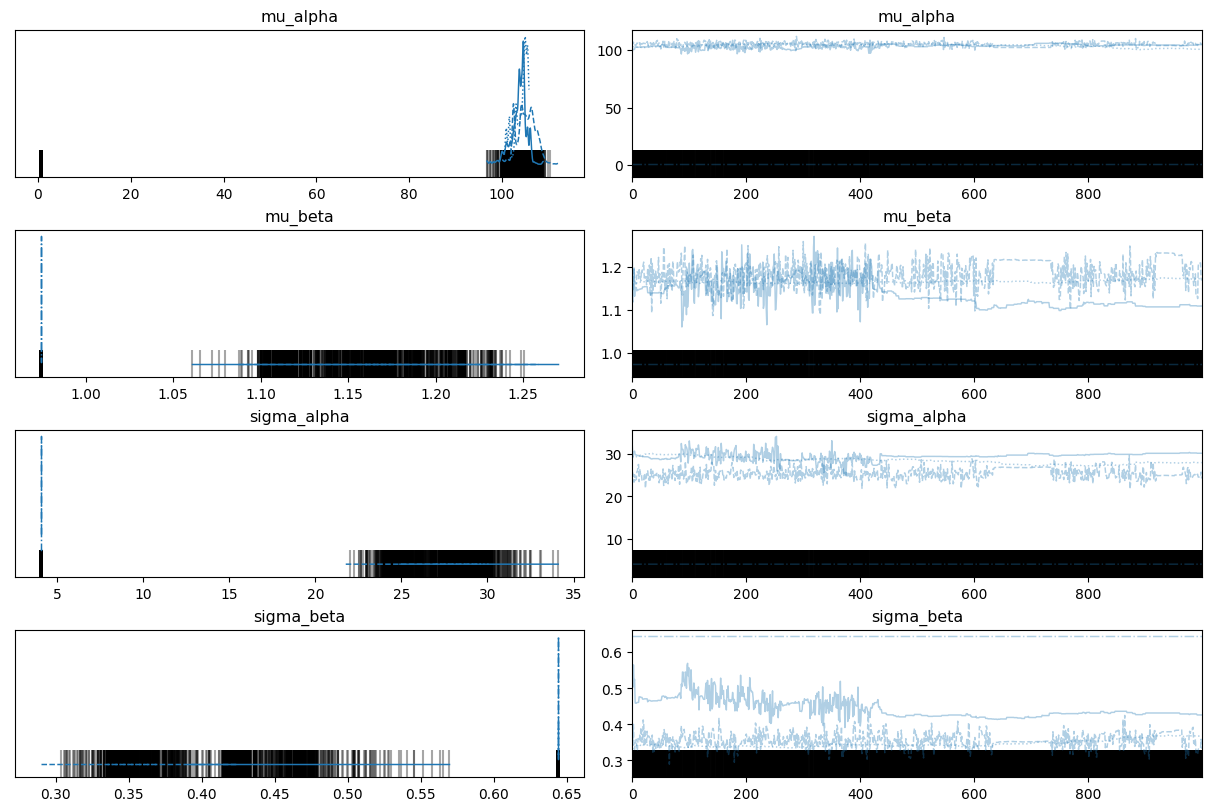

In [25]:
az.plot_trace(idata_bad_model, var_names=["mu_alpha", "mu_beta", "sigma_alpha", "sigma_beta"])
plt.show()

In [26]:
stop

NameError: name 'stop' is not defined

## Centered Parameterization
The centered parameterization uses the same parameter description as in the model description above. For many problems, this is not the recommended parametrization, as discussed [here](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) by Thomas Wiecki, one of the PyMC core devs.

However, in some cases, the centered parametrization actually performs better than the non-centered parameterization, see e.g. this [discussion](https://discourse.mc-stan.org/t/centered-vs-non-centered-parameterizations/7344).

In [ ]:
zips = theano.shared(d["zip_code"].values)
# idx variables cannnot used with pm.Data() so far, because of bug
# see here: https://discourse.pymc.io/t/integer-values-with-pm-data/3776
# and here: https://github.com/pymc-devs/pymc3/issues/3493

with pm.Model() as centered_hier_model:
    area = pm.Data("area", d["living_space_s"])
    #zips = pm.Data("zips", d["zip_code"].values)
    
    mu_alpha = pm.Normal("mu_alpha", mu=0, sd=20)
    sigma_alpha = pm.Exponential("sigma_alpha", lam=1/5)
    
    mu_beta = pm.Normal("mu_beta", mu=0, sd=5)
    sigma_beta = pm.Exponential("sigma_beta", lam=1/5)
    
    alpha = pm.Normal("alpha", mu=mu_alpha, sd=sigma_alpha, shape=num_zip_codes)
    beta = pm.Normal("beta", mu=mu_beta, sd=sigma_beta, shape=num_zip_codes)
    # without varying sigma
    sigma = pm.Exponential("sigma", lam=1/5)
    
    mu = alpha[zips] + beta[zips]*area
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d[target])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)

In [ ]:
data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=posterior_predictive,
                     coords={'zip_code': zip_codes},
                     dims={"alpha": ["zip_code"], "beta": ["zip_code"]})
data

In [ ]:
pm.save_trace(trace, directory="../models/centered_hier")

In [ ]:
data.to_netcdf("../models/centered_hier.nc")

In [ ]:
az.plot_trace(data.posterior.where(data.posterior.zip_code.isin(["12047"]), drop=True),
             var_names=["alpha"])
plt.show()

In [ ]:
az.summary(trace)

In [ ]:
az.plot_trace(trace, var_names=["mu_alpha", "mu_beta", "sigma_alpha", "sigma_beta", "sigma"])
plt.show()

## Non-Centered Version
Often, this reparametrization works better. For a more detailed explanation, I refer again to the [blog post](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) by Thomas Wiecki.

In [ ]:
with pm.Model() as non_centered_hier:
    
    beta_offset = pm.Normal("beta_offset", mu=0, sd=1, shape=num_zip_codes)
    
    mu_beta = pm.Normal("mu_beta", mu=0, sd=5)
    sigma_beta = pm.Exponential("sigma_beta", 1/5)
    beta = mu_beta + beta_offset*sigma_beta
    
    alpha_offset = pm.Normal("alpha_offset", mu=0, sd=1, shape=num_zip_codes)
    
    mu_alpha = pm.Normal("mu_alpha", mu=0, sd=20)
    sigma_alpha = pm.Exponential("sigma_alpha", 1/5)
    alpha = mu_alpha + alpha_offset*sigma_alpha
    
    mu = alpha[d.zip_code.values] + beta[d.zip_code.values]*d.living_space_s
    sigma = pm.Exponential("sigma", 1/5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d[target])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)

In [ ]:
az.summary(trace)

In [ ]:
az.plot_trace(trace, var_names=["mu_alpha", "mu_beta", "sigma_alpha", "sigma_beta", "sigma"])
plt.show()

## Multivariate Model (includes correlation)
Another way of coding a hierarchical model is to use a multivariate normal distribution for the random effects:
$$\begin{align*}
y &\sim \text{Normal}(\mu, \sigma)\\
\mu &= \alpha_{[ZIP]} + \beta_{[ZIP]} \text{area}\\
\\
\begin{bmatrix}\alpha_{[ZIP]} \\ \beta_{[ZIP]} \end{bmatrix} &\sim \text{Normal}( \begin{bmatrix} \mu_{\alpha} \\ \mu_{\beta} \end{bmatrix}, \Sigma)\\
\mu_{\alpha}, \mu_{\beta} &\sim \text{Normal}(0,100) \\
\end{align*}$$

Setting the prior for the $\Sigma$ matrix is a bit more involved. The [Stan User Guide](https://mc-stan.org/docs/2_18/stan-users-guide/multivariate-hierarchical-priors-section.html) gives some explanation for how to pick the matrix prior.

In [ ]:
with pm.Model() as correlation_hier_model: 
    # model specification is adapted from 
    # https://stackoverflow.com/questions/39364919/pymc3-how-to-model-correlated-intercept-and-slope-in-multilevel-linear-regressi
    # mu is mean vector for alpha and beta parameter
    mu = pm.Normal("mu", mu=0, sd=5, shape=(2,)) 
    # sigma is scale vector for alpha and beta parameter
    sigma = pm.Exponential("sigma", 1/5, shape=(2,))
    
    C_triu = pm.LKJCorr("C_triu", n=2, p=2)
    C = tt.fill_diagonal(C_triu[np.zeros((2,2), 'int')], 1.)
    # scale vector becomes diagonal of covariance matrix
    sigma_diag = tt.nlinalg.diag(sigma)
    cov = tt.nlinalg.matrix_dot(sigma_diag, C, sigma_diag)
    tau = tt.nlinalg.matrix_inverse(cov)
    
    # alpha and beta come from a multivariate normal
    # with mean vector mu
    # and covariance matrix tau 
    # tau includes scale for alpha and beta on the diagonals
    # and the correlation on  between alpha and beta off the diagonals
    ab = pm.MvNormal("ab", mu=mu, tau=tau, shape=(num_zip_codes, 2))
    
    sd_price = pm.Exponential("sd_price", lam=1/5)
    
    # compute estimate for price
    mean_price = ab[:,0][d.zip_code.values] + ab[:,1][d.zip_code.values]*d.living_space_s
    y = pm.Normal("y", mu=mean_price, sd=sd_price, observed=d[target])
    
    #prior = pm.sample_prior_predictive()
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)

In [ ]:
mvn_data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=posterior_predictive,
                     coords={'zip_code': zip_codes, 'param': ["alpha", "beta"],
                            "sigma_dim_0": ["alpha", "beta"]},
                     dims={"ab": ["zip_code", "param"],
                          "mu": ["param"]})
mvn_data

In [ ]:
mvn_data.to_netcdf("../models/mvn_hier.nc")

In [ ]:
pm.save_trace(trace, directory="../models/mvn_hier")

In [ ]:
az.summary(mvn_data)